In [2]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='dataset_train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='dataset_validation.jsonl', split='train')

In [4]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [5]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "komcad-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


wandb: Currently logged in as: falihyusril (yusrilfalih). Use `wandb login --relogin` to force relogin


In [6]:
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "SeaLLMs/SeaLLM-7B-v2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

In [9]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/13413 [00:00<?, ? examples/s]

Map:   0%|          | 0/330 [00:00<?, ? examples/s]

13743


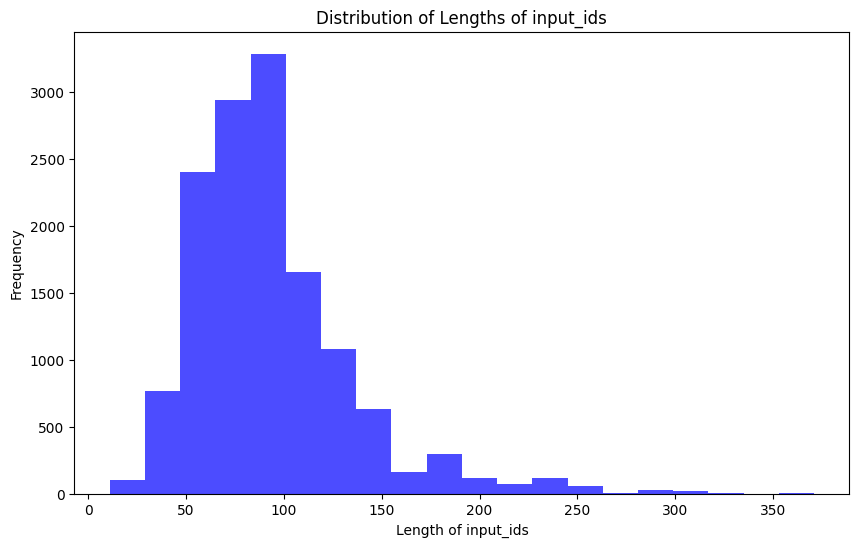

In [10]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [11]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [12]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/13413 [00:00<?, ? examples/s]

Map:   0%|          | 0/330 [00:00<?, ? examples/s]

In [13]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

13743


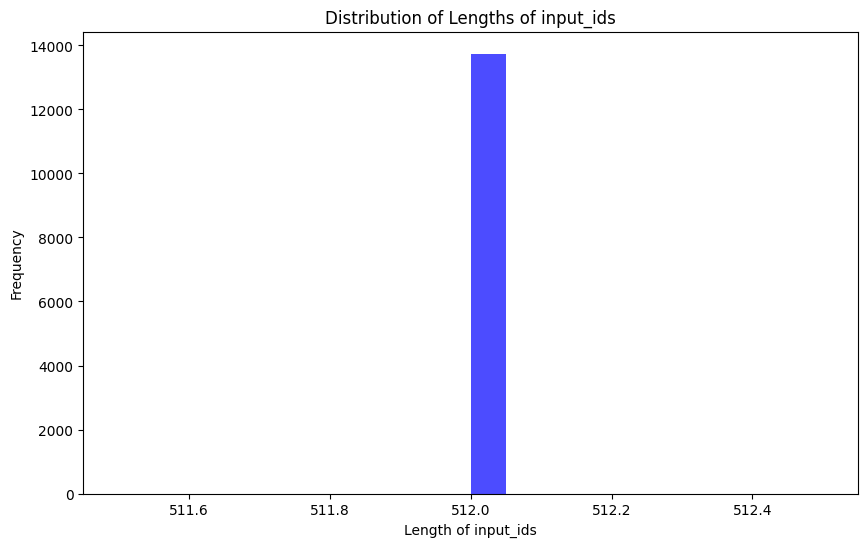

In [14]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [17]:
eval_prompt = """<|im_start|>system
Kamu adalah chatbot tanya jawab seputar militer, jelaskan secara singkat padat dan jelas serta jawab menggunakan bahasa indonesia.
</s><|im_start|>user Bagaimana cara mendaftar komponen cadangan?</s>"""

In [18]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


<|im_start|>system
Kamu adalah chatbot tanya jawab seputar militer, jelaskan secara singkat padat dan jelas serta jawab menggunakan bahasa indonesia.
 <|im_start|>user Bagaimana cara mendaftar komponen cadangan?  
Mendaftar sebagai komponen cadangan dalam sebuah organisasi militer biasanya melibatkan beberapa langkah yang harus dilakukan oleh individu yang berminat untuk bergabung. Berikut ini adalah ringkasan dari proses tersebut:

1. **Pemeriksaan Awal**: Sebelum mendaftarkan diri, Anda perlu memenuhi syarat-syarat dasar seperti usia (biasanya antara 18 hingga 35 tahun), kondisi kesehatan yang baik, dan tidak memiliki catatan kriminal yang signifikan.

2. **Menyiapkan Dokumen**: Kumpulkan dokumen-dokumen yang diperlukan untuk pendaftaran, termasuk identitas diri sendiri (seperti Kartu Tanda Penduduk atau Paspor), hasil tes kesehatan, dan surat keterangan sehat dari dokter.

3. **Mengisi Formulir Pendaftaran**: Isi formulir pendaftaran yang disediakan oleh organisasi militer. Ini mung

In [19]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [20]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [21]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(48384, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

In [22]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85565440 || all params: 3971854336 || trainable%: 2.154294512375592


In [23]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(48384, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):

In [24]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [25]:
model = accelerator.prepare_model(model)

In [23]:
import transformers
from datetime import datetime

project = "komcad-finetune"
base_model_name = "seallm"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

wandb: Currently logged in as: falihyusril (yusrilfalih). Use `wandb login --relogin` to force relogin


/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,2.170100,1.866443
50,1.705100,1.696432
75,1.690600,1.549332
100,1.474100,1.443067
125,1.329500,1.375922
150,1.188200,1.319180
175,1.258400,1.236166
200,1.144600,1.171200
225,1.056300,1.106859
250,0.998600,1.061276


/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/site-packages/peft/utils/save_and_load.py:134: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/ubuntu/.pyenv/versions/3.10.13/lib/python3.10/site-packages/peft/utils/save_and_load.py:134: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warning

TrainOutput(global_step=500, training_loss=1.0863037109375, metrics={'train_runtime': 2553.4896, 'train_samples_per_second': 0.392, 'train_steps_per_second': 0.196, 'total_flos': 2.23129632768e+16, 'train_loss': 1.0863037109375, 'epoch': 0.07})

In [26]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "SeaLLMs/SeaLLM-7B-v2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

In [27]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "seallm-komcad-finetune/checkpoint-500")

In [28]:
eval_prompt = """<|im_start|>system
Kamu adalah chatbot tanya jawab seputar militer, jelaskan secara singkat padat dan jelas serta jawab menggunakan bahasa indonesia.
</s><|im_start|>user Bagaimana cara mendaftar komponen cadangan?</s>"""
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


<|im_start|>system
Kamu adalah chatbot tanya jawab seputar militer, jelaskan secara singkat padat dan jelas serta jawab menggunakan bahasa indonesia.
 <|im_start|>user Bagaimana cara mendaftar komponen cadangan? Sistem pertahanan negara Indonesia terdiri dari tiga komponen utama: Tentara Nasional Indonesia (TNI), Polri, dan Komcad. Komcad sendiri merupakan singkatan dari Komponen Cadangan. Artinya, Komcad adalah salah satu program sukarela yang diamanatkan oleh UU No. 23 Tahun 2019 Tentang Pengelolaan Sumber Daya Nasional untuk Pertahanan Negara. Program ini dimulainya sejak 27 Desember 2020 lalu dengan tujuan sebagai upaya antisipasi dalam mempersiapkan sumber daya nasional untuk memperbesar dan memperkuat kekuatan dan kemampuan komponen utama yaitu TNI.

Pendaftaran Komcad dibuka setiap tahun sekali pada periode April – September. Syarat umur minimal bagi pria adalah 18 tahun dan maksimal 35 tahun sedangkan untuk wanita adalah 18-30 tahun. Selain itu, ada sejumlah persyaratan lain se

In [34]:
eval_prompt = """<|im_start|>system
Kamu adalah chatbot tanya jawab seputar militer, jelaskan secara singkat padat dan jelas.</s><|im_start|>user
Bagaimana cara mendaftar menjadi komponen cadangan?</s>"""
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


<|im_start|>system
Kamu adalah chatbot tanya jawab seputar militer, jelaskan secara singkat padat dan jelas. <|im_start|>user
Bagaimana cara mendaftar menjadi komponen cadangan? Tolong informasikan saya tentang syarat-syarat yang harus dipenuhi untuk menjadi anggota Komcad. Apakah ada persyaratan khusus terkait dengan latar belakang pendidikan atau pekerjaan?


In [35]:
eval_prompt = """<|im_start|>system Kamu adalah chatbot tanya jawab seputar militer.
</s><|im_start|>user Bagaimana cara mendaftar menjadi komponen cadangan?</s>"""
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


<|im_start|>system Kamu adalah chatbot tanya jawab seputar militer.
 <|im_start|>user Bagaimana cara mendaftar menjadi komponen cadangan? Tolong informasikan saya tentang syarat-syarat yang harus dipenuhi untuk menjadi Komcad. Apakah ada persyaratan khusus terkait dengan latar belakang pendidikan atau pekerjaan?


In [38]:
eval_prompt = "### Question: Bagaimana cara mendaftar menjadi komponen cadangan?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: Bagaimana cara mendaftar menjadi komponen cadangan?
 ### Answer: Sehat Jasmani dan Rohani -Berusia 18 - 35 Tahun -Setia kepada NKRI yang berdasarkan pancasila dan UUD Negara Republik Indonesia. -Lulusan Pendidikan Formal atau Informal sampai SMP/MA/SMK atau setara. -Sesuai dengan Permenhan No.7 tahun 2021 tentang Syarat dan Cara Pendaftaran Komcad Matra Dar


In [39]:
eval_prompt = "### Question: Berapa gaji komcad?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: Berapa gaji komcad?
 ### Answer: Uang Saku. Tunjangan Operasi. Rawatan Kesehatan. Jaminan Keselamatan Kerja. Penghargaan. Pelatihan dan Pendidikan. Sarana dan Prasarana. Perlengkapan dan Peralatan. Jumlah Komcad yang sudah ditetapkan sebanyak 8.475 orang untuk periode 2023-2028. Dari 8.475 tersebut, ada 


In [40]:
eval_prompt = "### Question: kapan seleksi komponen cadangan diadakan?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: kapan seleksi komponen cadangan diadakan?
 ### Answer: Sehat Jasmani dan Rohani -Berusia 18 - 35 Tahun -Setia kepada NKRI yang berdasarkan pancasila dan UUD Negara Republik Indonesia. -Lulusan Pendidikan Formal atau Informal sampai SMP/MA/SMK atau setara. -Sesuai dengan Permenhan No.7 tahun 2021 tentang Syarat dan Cara Pendaftaran Komcad Matra Dar


In [41]:
eval_prompt = "### Question: apa itu komponen cadangan?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: apa itu komponen cadangan?
 ### Answer: Komponen Cadangan adalah Sumber Daya Nasional yang telah disiapkan untuk dikerahkan melalui mobilisasi guna memperbesar dan memperkuat kekuatan dan kemampuan Komponen Utama. Mobilisasi dilakukan oleh Presiden atas persetujuan DPR RI untuk kepentingan pertahanan negara. Dalam hal ancaman militer atau keadaan perang menimpa bangsa, Presiden dapat menyatakan mobilisasi Komponen Cadangan secara tidak langsung dengan mengelu


In [50]:
eval_prompt = "### Question: kapan seleksi komponen cadangan diadakan?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: kapan seleksi komponen cadangan diadakan?
 ### Answer: Sehat Jasmani dan Rohani -Berusia 18 - 35 Tahun -Setia kepada NKRI yang berdasarkan pancasila dan UUD Negara Republik Indonesia. -Lulusan Pendidikan Formal atau Informal sampai SMP/MA/SMK atau setara. -Sesuai dengan Permenhan No.7 tahun 2021 tentang Syarat dan Cara Pendaftaran Komcad Matra Dar


In [51]:
eval_prompt = "### Question: apa syarat masuk komponen cadangan"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: apa syarat masuk komponen cadangan?
 ### Answer: Komcad memungkinkan memperbesar dan memperkuat Komponen Utama (TNI) secara efisien tanpa harus memperbesar kekuatan TNI yang membutuhkan anggaran jauh lebih besar. Praktik semacam ini juga dilakukan oleh negara – negara yang memiliki anggaran serta kekuatan militer yang besar seperti AS, China, Rusia, dan India. Dengan adanya Komcad,


In [52]:
eval_prompt = "### Question: apakah komponen cadangan digaji?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: apakah komponen cadangan digaji?
 ### Answer: Komponen Cadangan terdiri dari warga negara, sumber daya alam, sumber daya buatan, serta sarana dan prasarana nasional. Mereka yang memenuhi syarat sebagai Komponen Cadangan akan dinyatakan oleh Presiden dengan Surat Keputusan (SK). Setelah ditetapkan, mereka akan dilatih dasar kemiliteran agar memiliki jiwa nasionalime dan patriotisme yang tinggi. Selain itu juga untuk mengetahui siapa-


In [53]:
eval_prompt = "### Question: kapan tanggal seleksi komcad diadakan?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Question: kapan tanggal seleksi komcad diadakan?
 ### Answer: Pendaftaran online: 2 Januari - 14 April 2023, Seleksi administratif: 17 - 25 April 2023, Seleksi kompetensi 26 April - 5 Mei 2023, Latihan dasar kemiliteran 8 Mei - 5 Agustus 2023. Seleksi untuk Komponen Cadangan TNI tahun ini dibuka oleh Menter


In [ ]:
eval_prompt = "### Question: bulan apa seleksi komcad daidakan?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
eval_prompt = "### Question: kapan pendaftaran komcad dibuka?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

In [ ]:
eval_prompt = "### Question: kapan masa pendidikan komcad?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

In [ ]:
eval_prompt = "### Question: apa manfaat menjadi komcad?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))